In [1]:
import pickle

# Open the file with the correct encoding
with open(r'C:\Users\sheik\Documents\School\GeorgiaTech\3_2024Fall\DL\KID_PPG\code\data\PPG_FieldStudy\S1\S1.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')  # Adjust encoding if needed

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1

Showing the pickled data:
The data  0  is :  rpeaks
The data  1  is :  signal
The data  2  is :  label
The data  3  is :  activity
The data  4  is :  questionnaire
The data  5  is :  subject


In [2]:
data.keys()

dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])

In [3]:
data["signal"]

{'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
         [ 0.8556    , -0.06900001, -0.3646    ],
         [ 0.852     , -0.07020003, -0.3642    ],
         ...,
         [ 0.88759995, -0.1038    , -0.27920002],
         [ 0.88619995, -0.10159999, -0.27819997],
         [ 0.88680005, -0.10140002, -0.27380002]]),
  'ECG': array([[0.01560974],
         [0.01812744],
         [0.01753235],
         ...,
         [0.21368408],
         [0.21556091],
         [0.21702576]]),
  'EMG': array([[-1.5],
         [-1.5],
         [-1.5],
         ...,
         [-1.5],
         [-1.5],
         [-1.5]]),
  'EDA': array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
  'Temp': array([[-273.15],
         [-273.15],
         [-273.15],
         ...,
         [-273.15],
         [-273.15],
         [-273.15]], dtype=float32),
  'Resp': array([[ 4.4418335 ],
         [ 4.45098877],
         [ 4.47387695],
         ...,
         [-3.050

In [24]:
data["signal"]["wrist"]["BVP"].shape

(589568, 1)

In [4]:
data["signal"]["wrist"]["ACC"].shape

(294784, 3)

In [5]:
data["signal"]["chest"]["ECG"].shape

(6448400, 1)

In [6]:
data["label"].shape, len(data["signal"]["wrist"]["BVP"]) / 8

((4603,), 73696.0)

In [7]:
data["label"]

array([49.61136908, 50.32399248, 52.70833578, ..., 84.004991  ,
       85.79625673, 87.4113988 ])

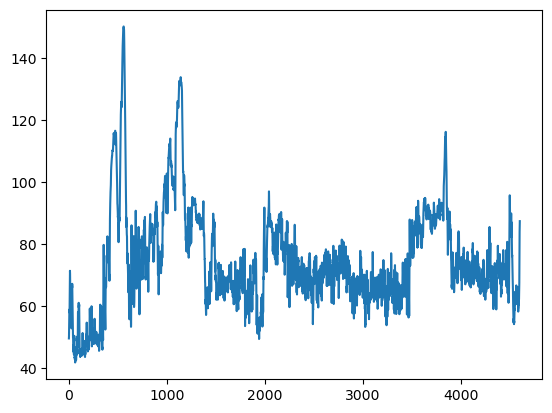

In [8]:
import matplotlib.pyplot as plt

plt.plot(data["label"])

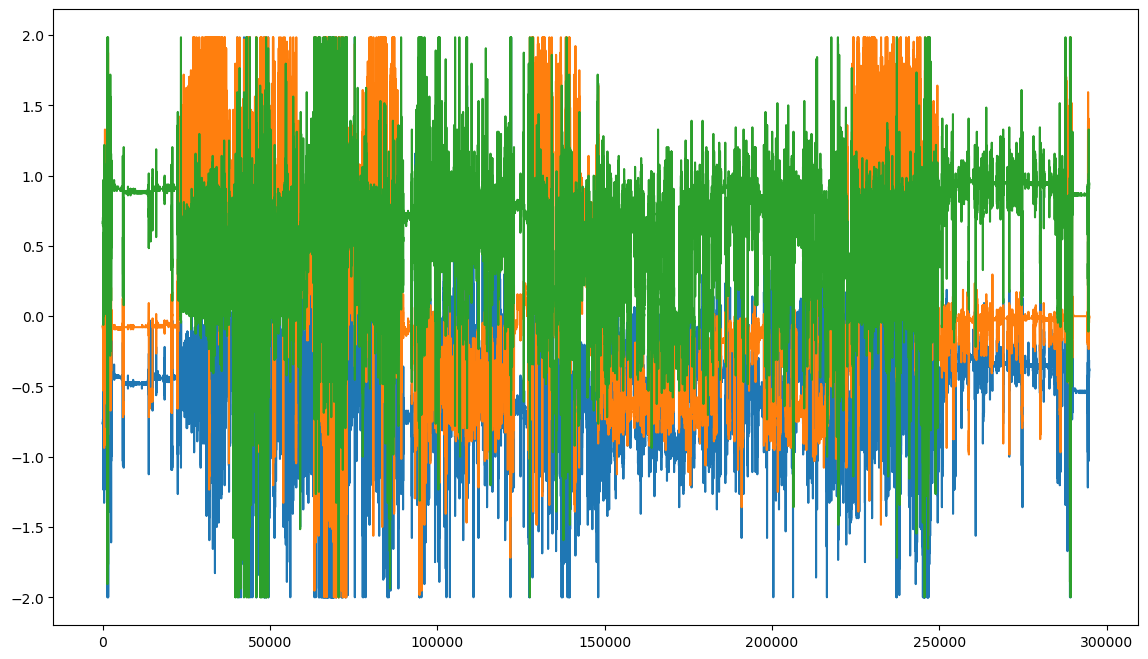

In [14]:
_ = plt.figure(figsize=(14, 8))
plt.plot(data["signal"]["wrist"]["ACC"])

In [ ]:
import torch
import torch.nn as nn
import torch.fft as fft
import torch.optim as optim

class AdaptiveFilteringModel(nn.Module):
    def __init__(self, local_optimizer, num_epochs_self_train=500, input_shape=(3, 256, 1), track_prediction_history=False):
        super(AdaptiveFilteringModel, self).__init__()
        
        self.num_epochs_self_train = num_epochs_self_train
        self.track_prediction_history = track_prediction_history
        self.prediction_history = []
        
        # Define the model layers with the correct kernel sizes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 21), padding='same')
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 1), padding='valid')

        # Optimizer
        self.local_optimizer = local_optimizer
        
        # Save the initial weights for reinitialization
        self.initial_weights = self.state_dict()

    def reinitialize_weights(self):
        # Reinitialize the weights to the initial state
        self.load_state_dict(self.initial_weights)
        
    def adaptive_loss(self, y_true, y_pred):
        # Reshape and compute the FFT of both true and predicted values
        y_true_fft = fft.fft(y_true)
        y_pred_fft = fft.fft(y_pred)

        # Compute the error in the frequency domain and return the squared loss
        e = torch.abs(y_true_fft - y_pred_fft)
        e = torch.sum(e ** 2, dim=-1)
        return torch.mean(e)
    
    def forward(self, x, y):
        # Use the full input (x) instead of slicing it
        self.train()  # Set the model in training mode

        for epoch in range(self.num_epochs_self_train):
            
            # Compute gradients and update model weights
            loss_value = self.adaptive_loss(y, self.model(x))
            self.local_optimizer.zero_grad()
            loss_value.backward()
            self.local_optimizer.step()
            
            # Track prediction history if specified
            if self.track_prediction_history:
                x_out = y - self.model(x)
                self.prediction_history.append(x_out)

        # Final output
        x_out = y - self.model(x)
        
        # Reinitialize model weights after training
        self.eval()  # Set the model in evaluation mode
        self.reinitialize_weights()

        return x_out
    
    def model(self, x):
        # Pass through the convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        return x[:, 0, :, 0]  # Extract the necessary part from the output

# Example usage
input_data = torch.randn((10, 3, 256, 1))  # Example batch of size 10 with input shape (batch, 3, 256, 1)
target_data = torch.randn((10, 1, 256, 1))  # Example target batch of size 10

# Define the optimizer
optimizer = optim.Adam(params=AdaptiveFilteringModel(local_optimizer=None).parameters())

# Initialize and train the model
model = AdaptiveFilteringModel(local_optimizer=optimizer)
for sampel in 
output = model(input_data, target_data)
print(output.shape)


RuntimeError: Given groups=1, weight of size [1, 1, 3, 1], expected input[1, 3, 256, 1] to have 1 channels, but got 3 channels instead

In [ ]:
import torch
import torch.nn as nn
import torch.fft as fft
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MotionArtifactSeparator(nn.Module):
    """Linear two-layer convolutional network for estimating motion artifacts."""
    def __init__(self):
        super(MotionArtifactSeparator, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=(3, 21), padding='same')  # Spatio-temporal filtering
        self.conv2 = nn.Conv2d(3, 1, kernel_size=(3, 1), padding = 'valid')  # Merge channels

    def forward(self, X_acc):
        x = self.conv1(X_acc)
        x = self.conv2(x)
        return x


class HRInferenceModel(nn.Module):
    """Full HR inference model including motion artifact separation."""
    def __init__(self, motion_separator):
        super(HRInferenceModel, self).__init__()
        self.motion_separator = motion_separator

    def forward(self, x_ppg, X_acc):
        x_ma_hat = self.motion_separator(X_acc)  # Estimate motion artifacts
        # x_bvp_hat = x_ppg - x_ma_hat  # Subtract estimated artifacts
        # return x_bvp_hat
        return x_ma_hat


def adaptive_filter_loss(predicted_ma, true_ppg):
    """Loss function based on FFT of predicted motion artifacts and true PPG."""
    pred_fft = fft.rfft(predicted_ma, dim=-1)
    true_fft = fft.rfft(true_ppg, dim=-1)
    mse_loss = nn.MSELoss()
    return mse_loss(torch.abs(pred_fft), torch.abs(true_fft))


# Data Preparation (Sample)
N_PPG = 8*64
N_ACC = 8*32
batch_size = 16

# Randomly simulate input data
x_ppg = torch.randn(batch_size, 1, 1, N_PPG)  # PPG signal
X_acc = torch.randn(batch_size, 3, 1, N_ACC)  # Accelerometer signals (3-axis)

# Dataset and Dataloader
dataset = TensorDataset(x_ppg, X_acc)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Optimizer, and Training Loop
motion_separator = MotionArtifactSeparator()
model = HRInferenceModel(motion_separator)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

epochs = 1000
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for x_ppg_batch, X_acc_batch in dataloader:
        optimizer.zero_grad()
        predicted_ma = motion_separator(X_acc_batch)
        loss = adaptive_filter_loss(predicted_ma, x_ppg_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_list.append(loss.item())

    if epochs % 1000 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# HR inference: Estimate BVP
x_bvp_hat = model(x_ppg, X_acc)  # Use the trained model for inference


RuntimeError: Calculated padded input size per channel: (1 x 256). Kernel size: (3 x 1). Kernel size can't be greater than actual input size

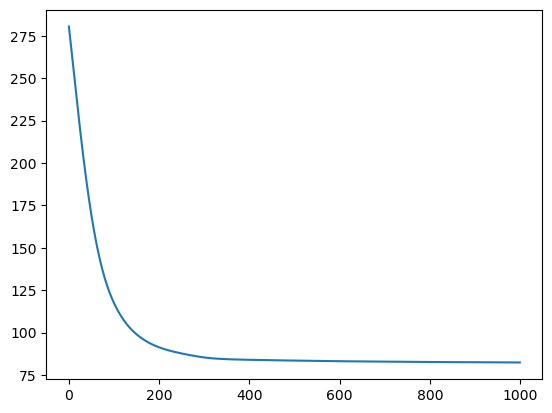

In [30]:
plt.plot(range(epochs), loss_list)